In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import json
import argparse

import astropy.cosmology
from astropy.cosmology import Planck18 #as cosmo
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

from numpy.fft import fftfreq

cosmo = FlatLambdaCDM(H0=67.66, Om0=0.30964)

hlittle = cosmo.H0.value / 100

def arcsec_to_cMpc(l_arcsec, z, with_hlittle=True):
    l_rad = l_arcsec * u.arcsec / u.radian
    l_cMpc = ( cosmo.comoving_transverse_distance(z) * l_rad ).to(u.Mpc).value
    if with_hlittle:
        l_cMpc *= hlittle
    return l_cMpc

def deg_to_cMpc(l_deg, z, with_hlittle=True):
    l_rad = l_deg * u.deg / u.radian
    l_cMpc = ( cosmo.comoving_transverse_distance(z) * l_rad ).to(u.Mpc).value
    if with_hlittle:
        l_cMpc *= hlittle
    return l_cMpc

def freq_to_comdis(nu_obs, nu_rest, with_hlittle=True):
    z = nu_rest / nu_obs - 1
    if z < 0:
        print("Error: z < 0")
        sys.exit(1)

    l = cosmo.comoving_distance(z).to(u.Mpc).value
    if with_hlittle:
        l *= hlittle
    return l

In [2]:
freq_21cm = 1420.40575177 # MHz

def _generate_noise_power(bins_kper, bins_kpar, signal_power, noise_mean, freq_obs, area_obs=25): 
    """
    input:
        bins_kpar: (Nk_para) edge values of k_para bins
        bins_kper: (Nk_perp) edge values of k_perp bins
        signal_power: (Nk_para, Nk_perp) cylindrical power spectrum
        noise_mean: (Nk_para, Nk_perp) mean noise power spectrum
        area_obs (float): area of the observation region [deg^2]
        freq_obs (list): min and max frequency [MHz]
    output:
        noise: (Nk_para, Nk_perp) one realization of noise power spectrum
    """
    
    redshift_mean = np.mean( freq_21cm / freq_obs - 1 )
    side_length = np.sqrt(area_obs) # [deg]        
    Lx = deg_to_cMpc(side_length, redshift_mean) # [cMpc/h]
    Ly = deg_to_cMpc(side_length, redshift_mean) # [cMpc/h]
    Lz = freq_to_comdis(freq_obs[0], freq_21cm) - freq_to_comdis(freq_obs[1], freq_21cm) # [cMpc/h]
    
    L = np.array([Lx, Ly, Lz])
    dx = 700 / 350 * hlittle # [cMpc/h] resolution adopted in simulation
    N = L / dx
    #freq = [fftfreq(n, d=d)*2*np.pi for n, d in zip(N, dx)]
    freq = [fftfreq(int(n), d=dx)*2*np.pi for n in N]
    kx, ky, kz = np.meshgrid(freq[0], freq[1], freq[2], indexing='ij')
    kpar = np.sqrt(kz**2)
    kper = np.sqrt(kx**2 + ky**2)

    ## compute angular-averaged power spectrum    
    n_kpar = len(bins_kpar)
    n_kper = len(bins_kper)
    err = np.zeros((n_kpar-1, n_kper-1))
    for i in range(n_kpar-1):
        for j in range(n_kper-1):
            mask = (kpar >= bins_kpar[i]) & (kpar < bins_kpar[i+1]) & (kper >= bins_kper[j]) & (kper < bins_kper[j+1]) 
            Nk = mask.sum()
            err[i,j] = (signal_power[i,j] + noise_mean[i,j]) / np.sqrt(Nk) #* np.random.normal(0, 1, 1)[0]


    return err


# Nk fitted to the given data
def generate_noise_power(bins_kper, bins_kpar, signal_power, noise_mean, Nk): 
    """
    input:
        bins_kpar: (Nk_para) edge values of k_para bins
        bins_kper: (Nk_perp) edge values of k_perp bins
        signal_power: (Nk_para, Nk_perp) cylindrical power spectrum
        noise_mean: (Nk_para, Nk_perp) mean noise power spectrum
        Nk: (Nk_perp) number of modes in the observation 
        
    output:
        noise: (Nk_para, Nk_perp) one realization of noise power spectrum
    """
    ## compute angular-averaged power spectrum    
    n_kpar = len(bins_kpar)
    n_kper = len(bins_kper)
    err = np.zeros((n_kpar-1, n_kper-1))
    for i in range(n_kpar-1):
        for j in range(n_kper-1):
            err[i,j] = (signal_power[i,j] + noise_mean[i,j]) / np.sqrt(Nk[j]) #* np.random.normal(0, 1, 1)[0]
    return err

In [3]:
base_dir = "./PS1_PS2_Data/"
model = "PS2"
frequency = np.loadtxt(f"{base_dir}/bins_frequency.txt")
redshift = freq_21cm / frequency - 1

k_para = np.loadtxt(f"{base_dir}bins_kpar.txt")
k_perp = np.loadtxt(f"{base_dir}/bins_kper.txt")
dkpar = k_para[1] - k_para[0]
dkper = k_perp[1] - k_perp[0]
bin_edges_kpar = np.zeros(len(k_para) + 1)
bin_edges_kper = np.zeros(len(k_perp) + 1)
bin_edges_kpar[1:] = k_para + dkpar / 2
bin_edges_kper[1:] = k_perp + dkper / 2
bin_edges_kpar[0] = k_para[0] - dkpar / 2
bin_edges_kper[0] = k_perp[0] - dkper / 2

frequencies = [ f"{fmin:.1f}_{fmax:.1f}" for fmin, fmax in zip(frequency[:,0], frequency[:,1]) ]
redshifts = [ f'$z$={zmin:.2f}-{zmax:.2f}' for zmin, zmax in zip(redshift[:,1], redshift[:,0]) ]

total_power = []
noise_mean = []
signal_power = []
noise_power = []
expected_err = []

for i in range(3):
    total_power.append(np.loadtxt(f'{base_dir}/Pk_{model}_{frequencies[i]}.txt'))
    noise_mean.append(np.loadtxt(f"{base_dir}/Pk_PS_averaged_noise_{frequencies[i]}.txt"))
    signal_power.append(total_power[i] - noise_mean[i])

    Nk = np.loadtxt(f"{base_dir}/Nk_{frequencies[i]}.txt")
    tmp = generate_noise_power(bin_edges_kpar, bin_edges_kper, signal_power[i], noise_mean[i], Nk)
    noise_power.append(tmp)

    tmp = np.loadtxt(f"{base_dir}/err_Pk_{model}_{frequencies[i]}.txt")
    expected_err.append(tmp)

print(frequencies)

['151.0_165.9', '166.0_180.9', '181.0_195.9']


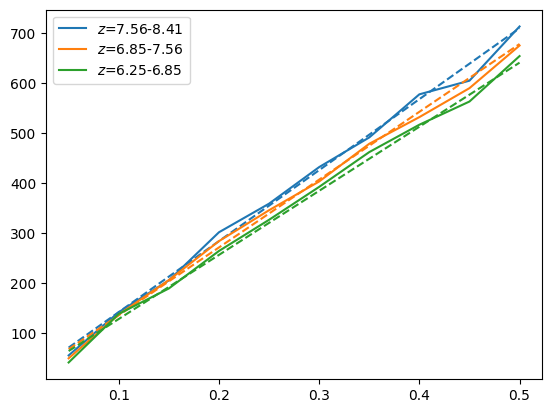

In [4]:
Nk_map = [ ( t / e ) ** 2 for t, e in zip(total_power, expected_err) ]
#plot_three(Nk_map, title="Nk_map")

V_list = []
z_list = [8, 7.2]
for i in range(3):
    freq_obs = frequency[i]
    Lz = freq_to_comdis(freq_obs[0], freq_21cm) - freq_to_comdis(freq_obs[1], freq_21cm) # [cMpc]    
    redshift_mean = np.mean(redshift[i])
    Lx = deg_to_cMpc(4, redshift_mean)
    V = Lx*Lx*Lz
    V_list.append(V)

# Nmode(k_para, k_perp) = V * k_perp * dk_perp * dk_para / (2pi)^2
factor_list = [0.71, 0.75, 0.78] # Unknow factor...
plt.figure()
for i in range(3):
    num_mode = Nk_map[i]
    line = plt.plot(k_perp, num_mode[0], label=redshifts[i]) 
    y = V_list[i] * k_perp * dkper * dkpar / (2*np.pi)**2 * factor_list[i]
    line_color = line[0].get_color()
    plt.plot(k_perp, y, linestyle='--', color=line_color)

plt.legend()

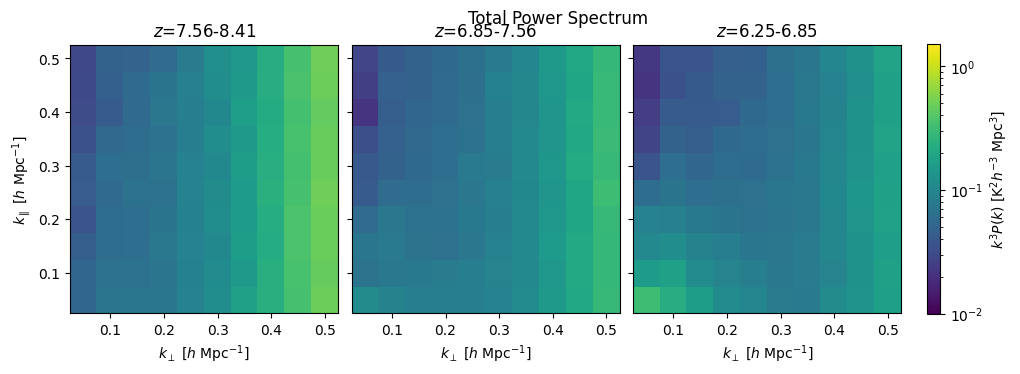

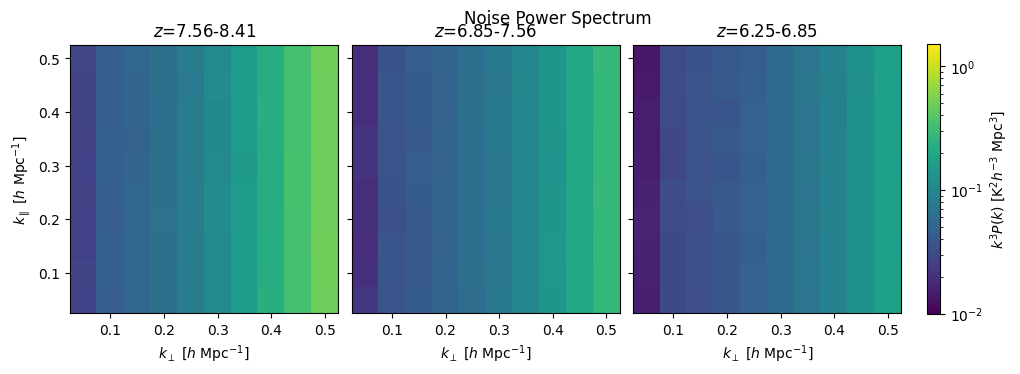

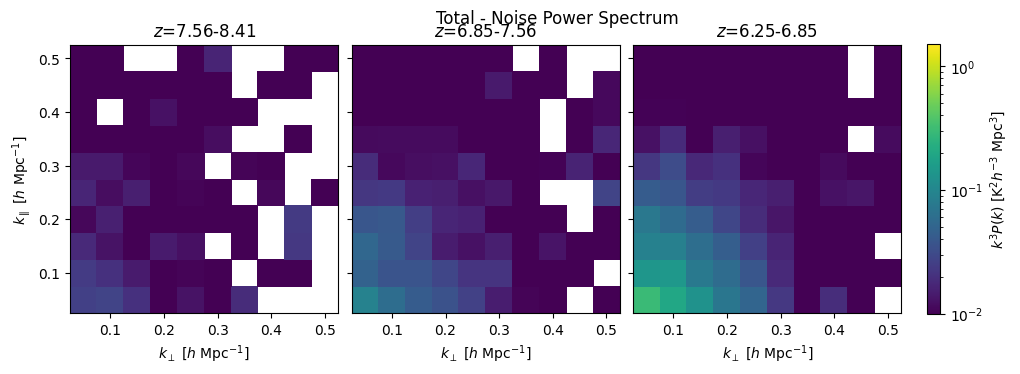

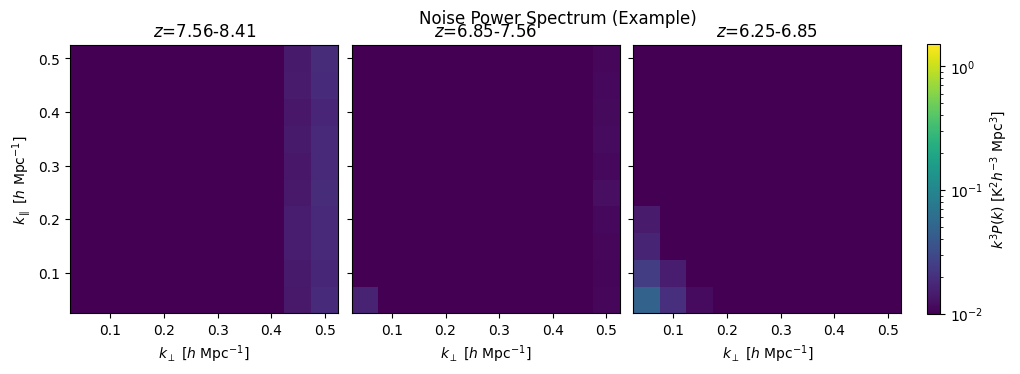

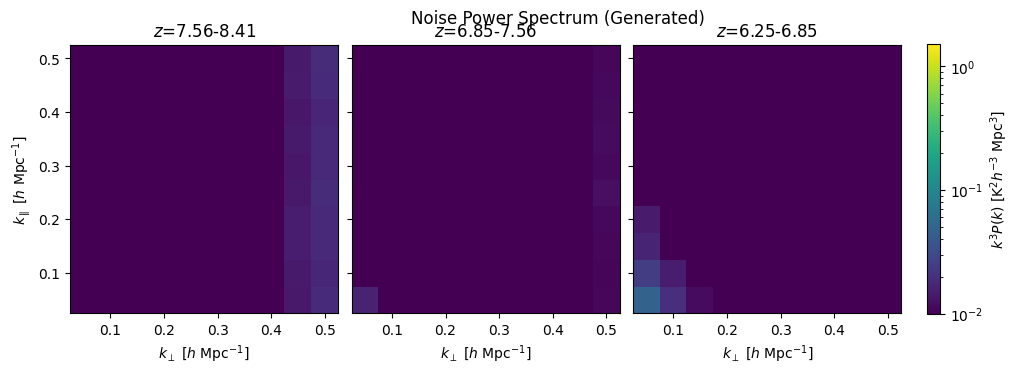

In [5]:
import matplotlib.colors as colors

def plot_three(power_2d, title=None, logscale=True, vmin=1e-2, vmax=1.5):
    fig, ax = plt.subplots(1,3,gridspec_kw=dict(width_ratios=[1,1,1],wspace=0.05),sharex='col', sharey='row', figsize=(13,3.5))
    plt.suptitle(title)
    for i in range(3):
        if logscale:
            cs = ax[i].pcolor(k_perp,k_para,power_2d[i], norm=colors.LogNorm(vmin=vmin, vmax=vmax))
        else:
            cs = ax[i].pcolor(k_perp,k_para,power_2d[i])

        #cs = ax[i].pcolor(bin_edges_kper,bin_edges_kpar,power_2d[i]) #*1.0e6, norm=colors.LogNorm(vmin=1.0e4, vmax=1.5e6))
        ax[i].set_aspect('equal')
        ax[i].set_xlabel("$k_\perp$ [$h$ Mpc$^{-1}$]")
        ax[i].set_title(redshifts[i])
    ax[0].set_ylabel("$k_\parallel$ [$h$ Mpc$^{-1}$]")
    cbar = fig.colorbar(cs, ax=ax.ravel().tolist(), pad=0.025)
    cbar.set_label('$k^3 P(k)$ [K$^2 h^{-3}$ Mpc$^3$]')

plot_three(total_power, title="Total Power Spectrum")
plot_three(noise_mean, title="Noise Power Spectrum")
plot_three(signal_power, title="Total - Noise Power Spectrum")
plot_three(expected_err, title="Noise Power Spectrum (Example)")
plot_three(noise_power, title="Noise Power Spectrum (Generated)")

# No normalization
# No normalization
-1.5107046


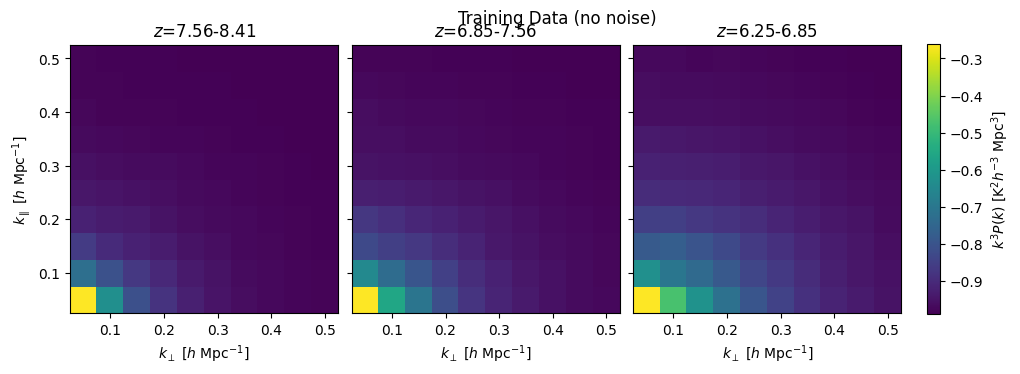

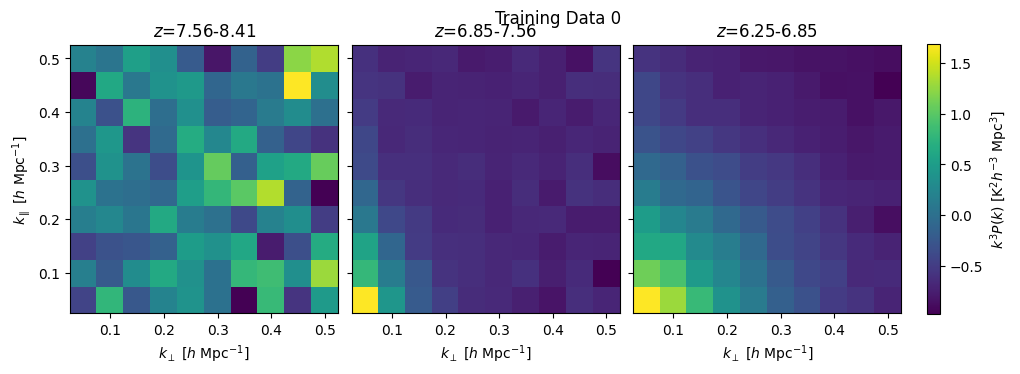

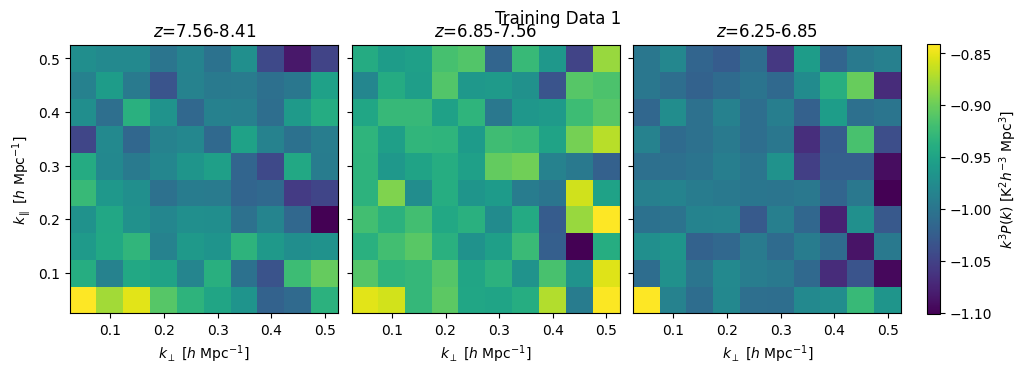

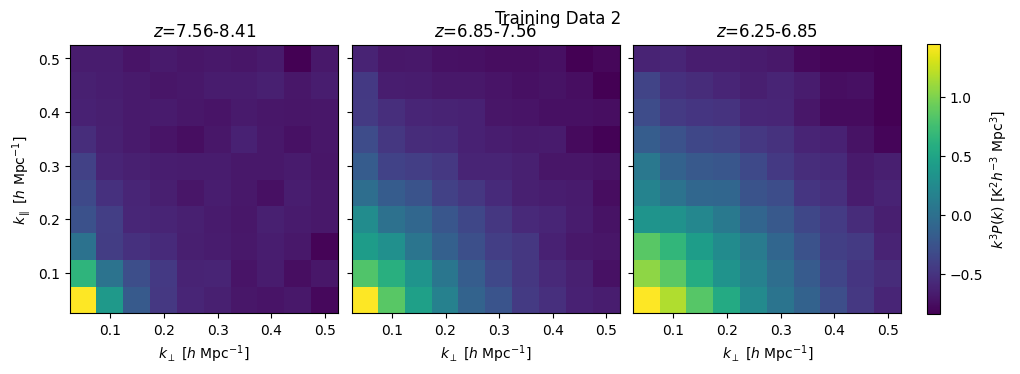

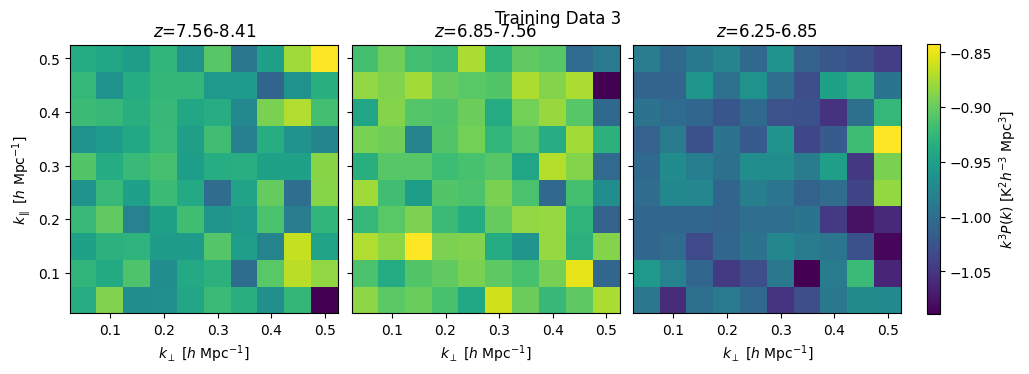

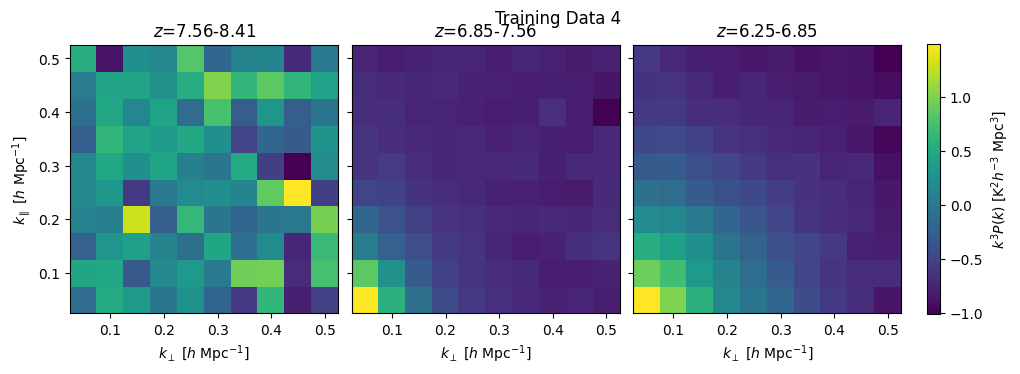

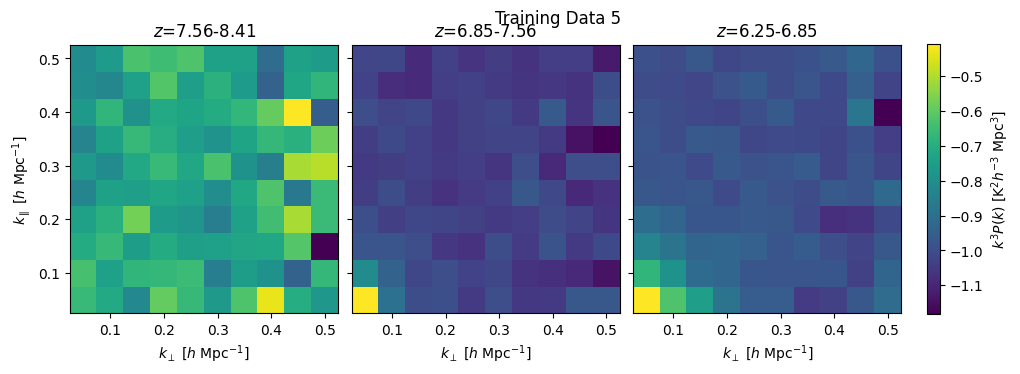

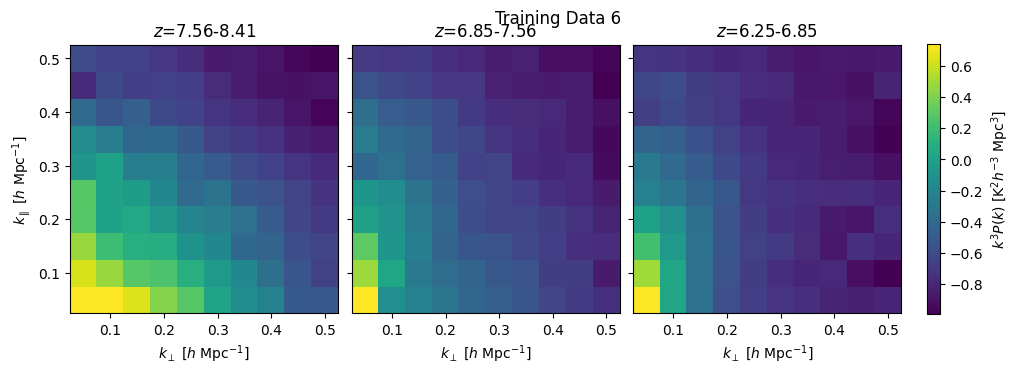

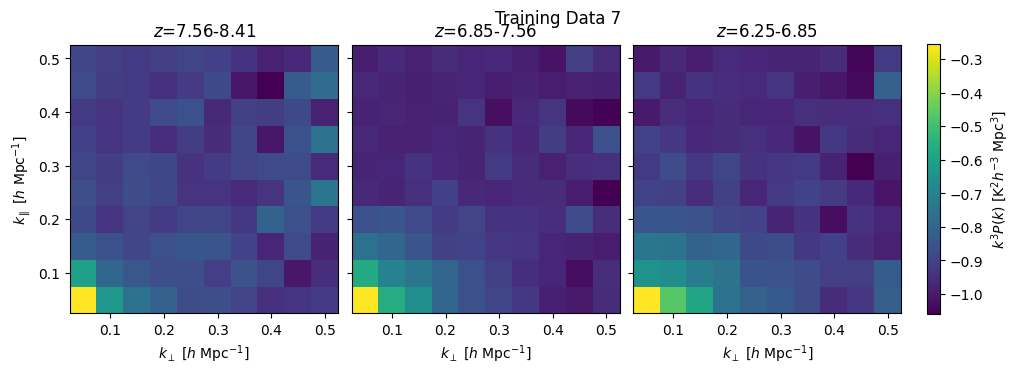

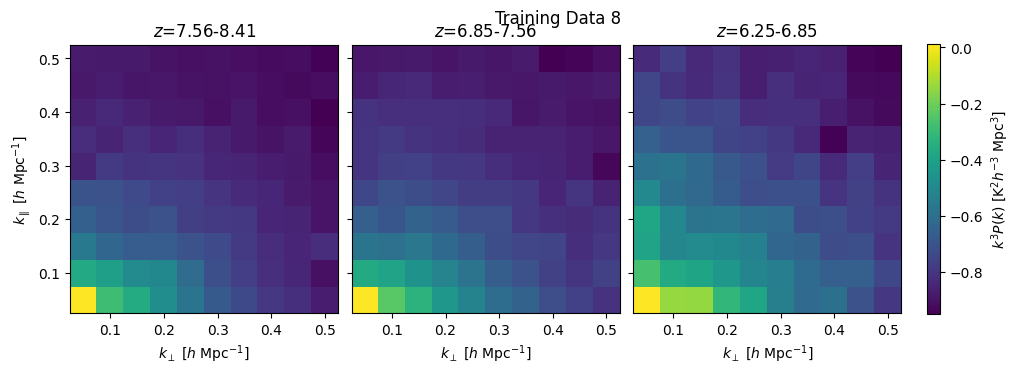

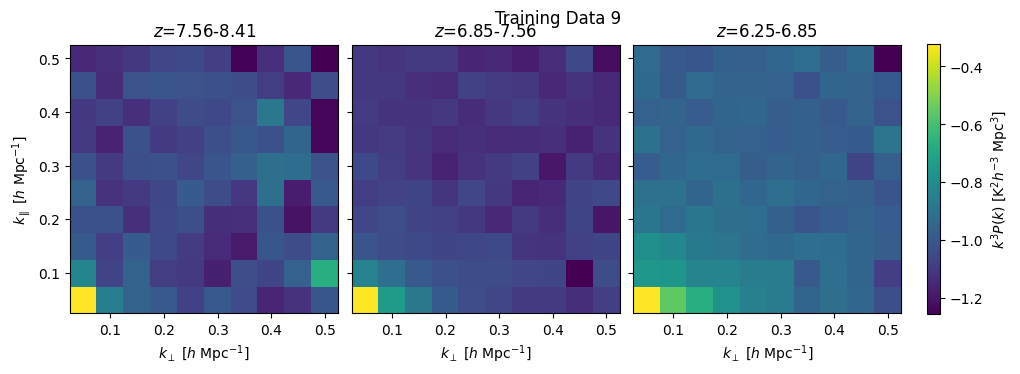

In [8]:
from utils import *

data_dir = "./TrainingData/dataset_700Mpc_250"
data, label, _, _ = load_SDC3b_data(data_dir, ndata=10)
data_npy = data.detach().numpy()

for i in range(7,8):
    plot_three(data_npy[i], title="Training Data (no noise)", logscale=False)

data, label, _, _ = load_SDC3b_data(data_dir, ndata=400, add_noise=True)
data_npy = data.detach().numpy()
print(data_npy.min())

for i in range(10):
    plot_three(data_npy[i], title=f"Training Data {i}", logscale=False)
    #plot_three(data_npy[i], title=f"Training Data {i}", logscale=True, vmin=None, vmax=None)